In [1]:
# This is used to read fits files 
from astropy.io import fits

# Useful for a bunch of stuff
import numpy as np

# Used for Log plots
from matplotlib.colors import LogNorm

# Prettier plots
import seaborn as sns

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib.pyplot as plt 
%matplotlib inline 
%config InlineBackend.figure_formats = ('png', 'retina')

# Used for median filter to handle noise
from scipy import ndimage

# Used to regrid data
from scipy.interpolate import griddata

# Used to time regreidding
import time

In [33]:
def extract_FITS(filename):
    '''
       Extracts the data cube from the FITS file.
       
       Arguments: 
           filename : name of the file including path
           
       Return variables:
           hdu_list : hdu_list[0].data contains the data cube array in order of wavelength, y, x
           Min      : the starting wavelength value in the cube in Angstroms
           Max      : the ending wavelength value in the cube in Angstroms
           Step     : the step size of the wavelength
           xlen     : the size of the horizontal axis of FOV in arcseconds
           ylen     : the size of the horizontal axis of FOV in arcseconds
    '''
    
    hdu_list = fits.open(filename)
    image, header = fits.getdata(filename, header=True)
    Min = header['CRVAL3']
    step = header['CD3_3']
    Max = Min +  (np.shape(image)[0] - 1) * step
    ypixel = len(hdu_list[0].data[0])
    xpixel = len(hdu_list[0].data[0][0])
    xlen = (header['CD1_1']**2 + header['CD2_1']**2)**(0.5) * xpixel * 3600
    ylen = (header['CD1_2']**2 + header['CD2_2']**2)**(0.5) * ypixel * 3600
    return hdu_list, Min, Max, step, xlen, ylen

def wave2pix(wave, color):
    '''
       Converts a given wavelength value into the corresponding pixel of the specified cube.
       
       Arguments:
           wave     : the wavelength value 
           color    : blue, green, or red
        
       Return variables: 
           pixel    : the pixel value 
    '''
    
    if color == "blue":
        return int((wave - Min_blue) / step_blue)
            
    if color == "green":
        return int((wave - Min_green) / step_green)
            
    if color == "red":
        return int((wave - Min_red) / step_red)
    
def make_sum(start_wv, end_wv, color):
    '''
       Makes a direct sum of a set of images in a specified wavelength span. 
       
       Arguments:
           start_wv : the starting wavelength value  
           end_wv   : the ending wavelength value 
           color    : blue, green, or red
        
       Return variables: 
           sum_img  : the summed image
    '''
    
    sum_img = 0
    start = wave2pix(start_wv, color)
    end = wave2pix(end_wv, color)
    length = -start + end
    
    if color == "blue":
        for i in range(length+1):
            sum_img += hdu_list_blue[0].data[start + i]
            
    if color == "green":
        for i in range(length+1):
            sum_img += hdu_list_green[0].data[start + i]
            
    if color == "red":
        for i in range(length+1):
            sum_img += hdu_list_red[0].data[start + i]
            
    return sum_img

    
def plot_hist(sum_img, hist_range=0):
    '''
       Displays a histogram of a summed image. Useful for deciding the colorbar. 
       
       Arguments:
           sum_img      : the summed image  
           hist_range   : (optional) specify a particular range for the x-axis
        
       Return variables: 
           none
    '''
    
    plt.figure(figsize=(9,4))
    if hist_range: 
        plt.hist(sum_img.flatten(), 100, range=hist_range)
    else:
        plt.hist(sum_img.flatten(), 100)
    plt.show()
    
    
def plot_sum(sum_img, minpix, maxpix):
    '''
       Plots a summed image.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
        
       Return variables: 
           none
    '''
    
    plt.imshow(sum_img, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen, 0, ylen])
    ax = plt.gca();
    ax.set_yticks(np.arange(0, ylen, 2));
    ax.set_xticks(np.arange(0, xlen, 2));
    plt.xlabel('x (\u2033)');
    plt.ylabel('y (\u2033)');
    plt.colorbar()
    
def extract_back(sum_img, minpix, maxpix):
    '''
       Extracts the sky background in a summed image. The extracted background is shown
       as a white box.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
        
       Return variables: 
           median   : the median value of the sky background
           std      : the standard deviation value of the sky background 
    '''
    
    sum_imgc = np.copy(sum_img);
    back = [];
    for i in range(13):
        for j in range(18):
            back.append(sum_img[135 + i][5 + j])
            sum_imgc[135 + i][5 + j] = None
    plot_sum(sum_imgc, minpix, maxpix)
    median = np.median([i for i in back if i > 0])
    std = np.std(back)
    return median, std

def remove_noise(sum_img, minpix, maxpix, num):
    '''
       Removes all pixels that are a specified factor of the standard deviation above the 
       median of the sky background.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
           num      : the specified factor (median + num * std)
        
       Return variables: 
           sum_img  : the summed image with pixels above the threshold removed
    '''
    
    median, std = extract_back(sum_img, minpix, maxpix)
    plt.show()
    sum_imgc = np.copy(sum_img);
    for i in range(len(sum_img)):
        for j in range(len(sum_img[0])):
            if sum_imgc[i][j] <= median + num * std:
                sum_imgc[i][j] = None
    plot_sum(sum_imgc, minpix, maxpix)
    plt.show()
    return sum_imgc
    
def regrid_cube(color, center, low, high, sep=False):
    '''
       Regrids a 3D data cube array with velocity points of multiples of 10. 
       
       Arguments:
           color            : blue, green, or red  
           center           : line center wavelength
           low              : line lowest wavelength
           high             : line highest wavelength
           sep              : (optional) used to separate 3726 and 3729
        
       Return variables: 
           new_vvals        : 1D array of the velocity axis values
           new_hdu_list_re  : regridded cube with flux conserved
    '''   
    
    if color == "blue":
        hdu_list = hdu_list_blue
        step = step_blue
        
    if color == "green":
        hdu_list = hdu_list_green
        step = step_green
        
    if color == "red":
        hdu_list = hdu_list_red
        step = step_red
    
    # Creating a wavelength list 
    wv_lst = np.arange(low, high+step, step)
    
    # Converting to velocity space
    old_vvals = 299792.458 * ((wv_lst  - center) / center)
    v_step_old = np.mean([old_vvals[1] - old_vvals[0], old_vvals[-1] - old_vvals[-2]])
    print("original velocity step size = {}".format(v_step_old))
    
    # Rounding initial and final velocity point to nearest multiple of 10 
    v_low = old_vvals[0]
    v_high = old_vvals[-1]
    print("v_low = {}, v_high = {}".format(v_low, v_high))
    grid_low = round(v_low / 10.0) * 10.0
    grid_high = round(v_high / 10.0) * 10.0
    print("grid_low = {}, grid_high = {}".format(grid_low, grid_high))
    
    # Regridding to new velocity coordinates 
    new_vvals = np.arange(grid_low, grid_high + 10, 10)
    yvals = np.linspace(0, ylen, np.shape(hdu_list[0].data)[1])
    xvals = np.linspace(0, xlen, np.shape(hdu_list[0].data)[2])
    old_grid_y, old_grid_v, old_grid_x = np.meshgrid(yvals, old_vvals, xvals)
    new_grid_y, new_grid_v, new_grid_x = np.meshgrid(yvals, new_vvals, xvals)
    v_lst = old_grid_v.flatten()
    y_lst = old_grid_y.flatten()
    x_lst = old_grid_x.flatten()
    f_lst = hdu_list[0].data[wave2pix(low, color):wave2pix(high+step, color),:,:].flatten()
    
    if not sep: 
        start = time.time()
        new_hdu_list = griddata((v_lst, y_lst, x_lst), f_lst, (new_grid_v, new_grid_y, new_grid_x), method='nearest') 
        end = time.time()
        
    else: 
        f_mod = np.array([])
        for i in range(len(sep)):
            f_mod = np.concatenate((f_mod, sep[i] * f_lst[i*len(yvals)*len(xvals) : (i+1)*len(yvals)*len(xvals)]))
            
        start = time.time()
        new_hdu_list = griddata((v_lst, y_lst, x_lst), f_mod, (new_grid_v, new_grid_y, new_grid_x), method='nearest') 
        end = time.time()
        
    # Conserving flux 
    new_hdu_list_re = new_hdu_list * 10.0 / v_step_old
    print("runtime  = {} minutes".format(((end - start) / 60.0)))
    
    return new_vvals, new_hdu_list_re

def check_cube(vvals, cube, center, low, high, minpix, maxpix):
    ''' 
       Checks the regridded cube by plotting position position contour maps. 
       
       Arguments:
           vvals   : 1D array of the velocity axis values
           cube    : regridded cubic array 
           center  : line center wavelength
           low     : line lowest wavelength   
           high    : line highest wavelength
           minpix  : the min value of the colorbar
           maxpix  : the max value of the colorbar
        
       Return variables: 
           sum_img : the summed image
    ''' 
    
    # Converting to velocity space 
    v_low = 299792.458 * ((low  - center) / center)
    v_high = 299792.458 * ((high  - center) / center)
    grid_low = round(v_low / 10.0) * 10.0
    grid_high = round(v_high / 10.0) * 10.0
    pix_low, = np.where(vvals == grid_low)[0]
    pix_high, = np.where(vvals == grid_high)[0]
    print("v_low = {}, v_high = {}".format(v_low, v_high))
    
    # Creating summed image 
    sum_img = 0
    length = -pix_low + pix_high
    for i in range(length+1):
        sum_img += cube[pix_low + i]
    
    # Plotting image 
    plot_hist(sum_img)
    plt.imshow(sum_img, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen, 0, ylen])
    ax = plt.gca();
    ax.set_yticks(np.arange(0, ylen, 2));
    ax.set_xticks(np.arange(0, xlen, 2));
    plt.xlabel('x (\u2033)');
    plt.ylabel('y (\u2033)');
    plt.colorbar() 
    
    return sum_img

def match_grids(new_vvals1, new_cube1, new_vvals2, new_cube2):
    '''
       Slices the larger image to match the new grids of the smaller image
       so the two can be used for addition. 
       
       Arguments: 
           new_vvals1            : velocity points of first regridded image
           new_cube1             : first regridded image
           new_vvals2            : velocity points of second regridded image
           new_cube2             : second regridded image
           
        Return variables:
           new_vvals1[a:b]       : matched velocity points 
           new_cube1[a:b,:,:]    : matched first regridded image
           new_cube2[c:d,:,:]    : matched second regridded image 
    '''
    
    a = 0
    b = len(new_vvals1)
    c = 0
    d = len(new_vvals2)
    
    if np.min(new_vvals1) <= np.min(new_vvals2):
        a, = np.where(new_vvals1==np.min(new_vvals2))[0]
        
    else: 
        c, = np.where(new_vvals2==np.min(new_vvals1))[0]
        
    if np.max(new_vvals1) >= np.max(new_vvals2):
        b, = np.where(new_vvals1==np.max(new_vvals2))[0] + 1
        
    else:
        d, = np.where(new_vvals2==np.max(new_vvals1))[0] + 1
    
    return new_vvals1[a:b], new_cube1[a:b,:,:], new_cube2[c:d,:,:]

In [3]:
image_blue  = 'surf2018/data/cubes/s_HH32abd-OII3727.fits'
image_green = 'surf2018/data/cubes/s_HH32abd-OIII5007.fits'
image_red   = 'surf2018/data/cubes/s_HH32abd-OI6300.fits'

hdu_list_blue, Min_blue, Max_blue, step_blue, xlen, ylen = extract_FITS(image_blue)
hdu_list_green, Min_green, Max_green, step_green, xlen, ylen = extract_FITS(image_green)
hdu_list_red, Min_red, Max_red, step_red, xlen, ylen = extract_FITS(image_red)

# Update default figure and font size
plt.rcParams["figure.figsize"] = [9, 7]
plt.rcParams.update({'font.size': 10})

In [4]:
s6300_vvals, s6300_cube = regrid_cube("red", 6300.31, 6294.00, 6310.75)

original velocity step size = 11.89594075529618
v_low = -300.2535446636943, v_high = 496.7744859411489
grid_low = -300.0, grid_high = 500.0
runtime  = 0.06039872169494629 minutes


v_low = -38.542848047178616, v_high = 377.8150783881872


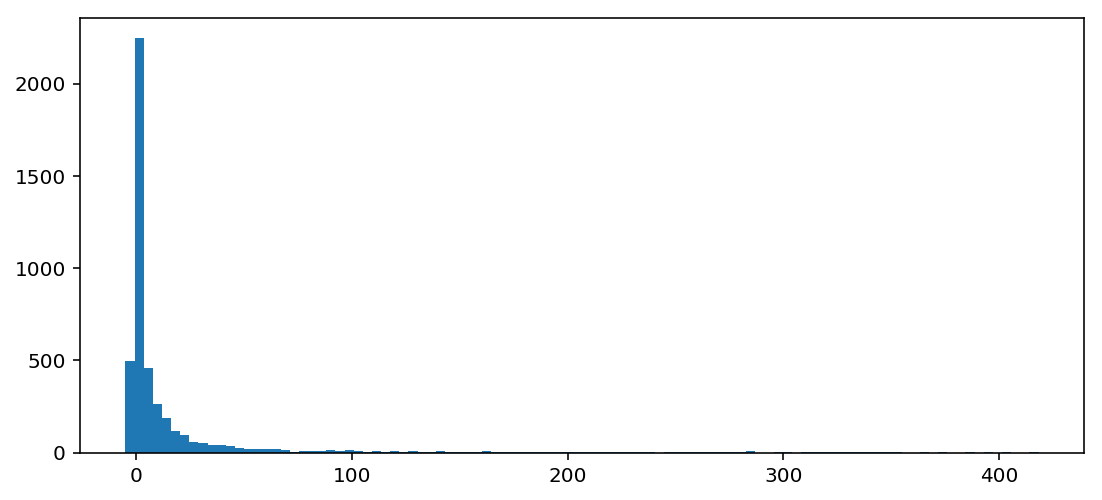

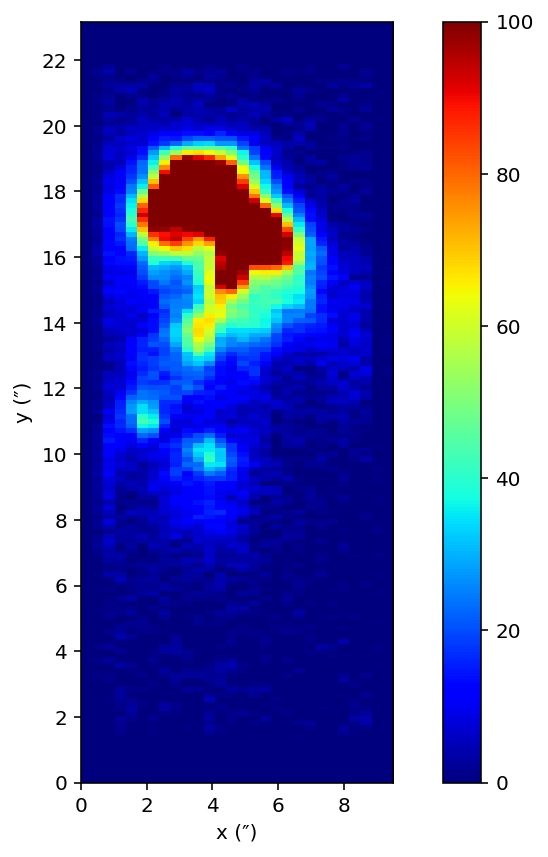

In [5]:
test_s6300 = check_cube(s6300_vvals, s6300_cube, 6300.31, 6299.50, 6308.25, 0, 100)

In [6]:
s5577_vvals, s5577_cube = regrid_cube("red", 5577.34, 5571.75, 5586.75)

original velocity step size = 13.437967651245941
v_low = -300.4729566818669, v_high = 505.8051023928891
grid_low = -300.0, grid_high = 510.0
runtime  = 0.07188133796056112 minutes


v_low = 35.47623459928145, v_high = 62.35216990177331


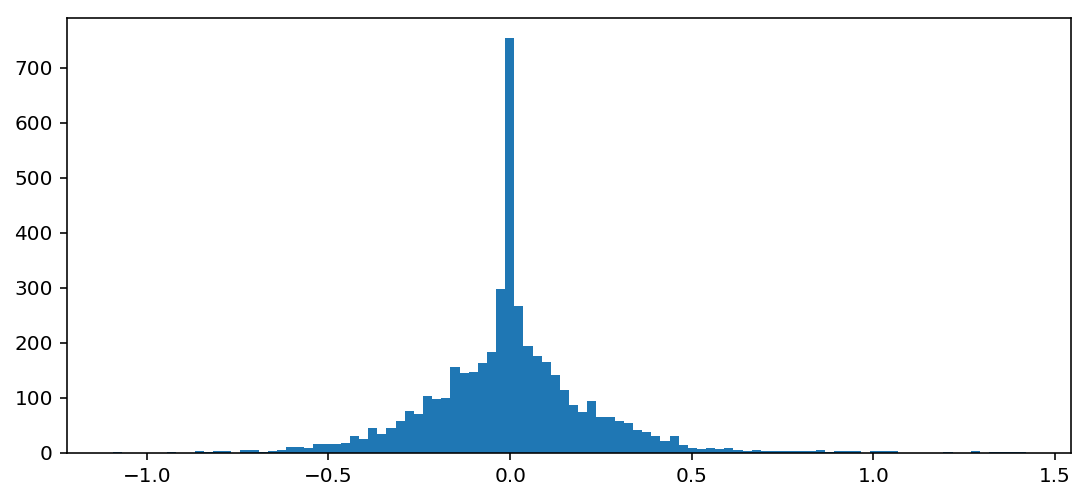

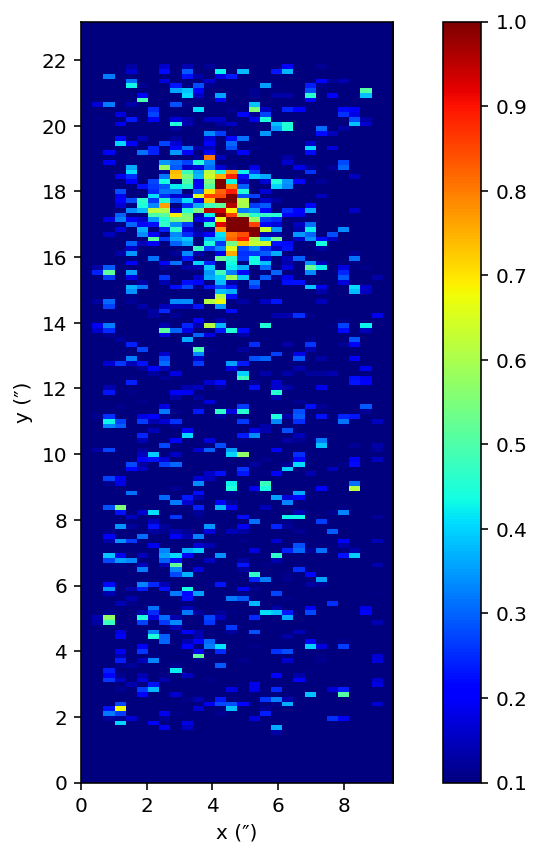

In [7]:
test_s5577 = check_cube(s5577_vvals, s5577_cube, 5577.34, 5578.00, 5578.50, 0.1, 1)

v_low = -38.542848047178616, v_high = 377.8150783881872


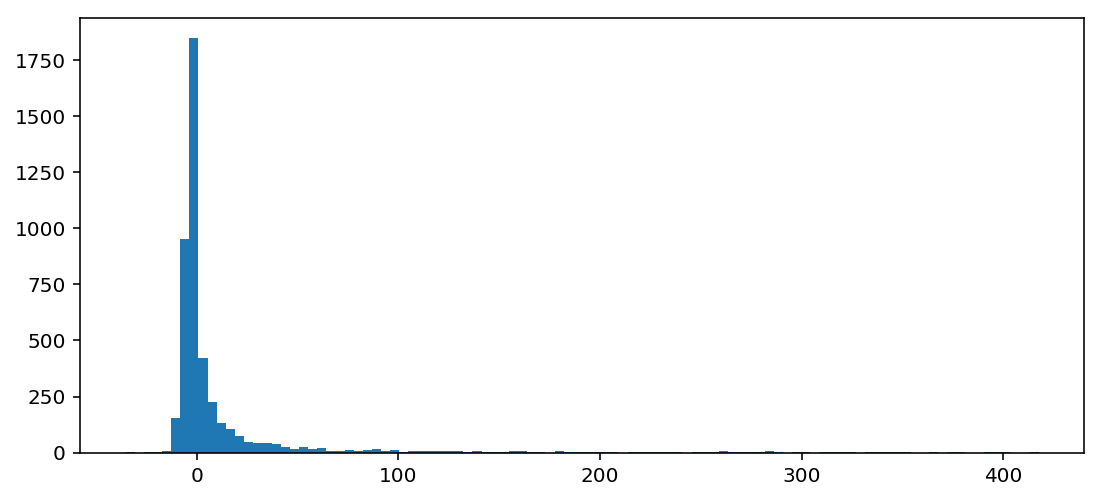

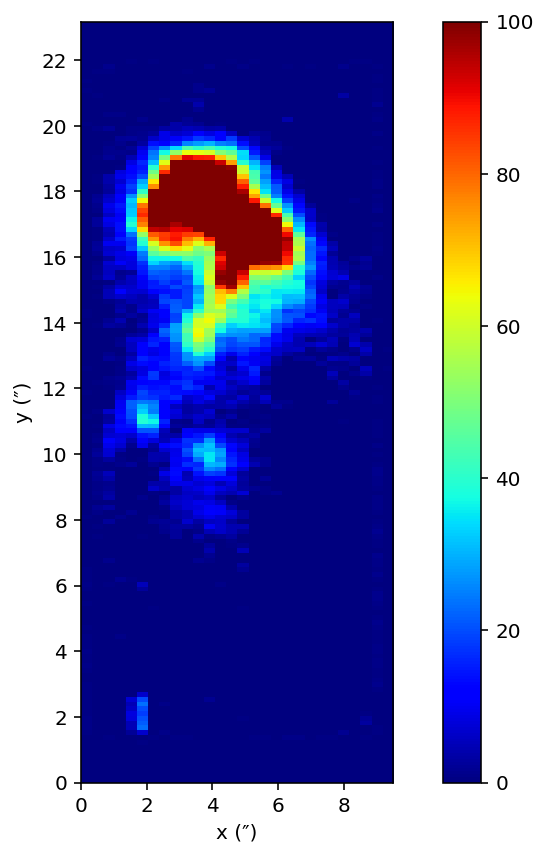

In [8]:
m_vvals, m_s6300, m_s5577 = match_grids(s6300_vvals, s6300_cube, s5577_vvals, s5577_cube)
oi_cube = m_s6300 + m_s5577

test_oi = check_cube(m_vvals, oi_cube, 6300.31, 6299.50, 6308.25, 0, 100)

In [9]:
np.save("oi_cube.npy", oi_cube)
hdu = fits.PrimaryHDU()
hdu.data = oi_cube

hdu.header['CUNIT1'] = ('deg     ', "RA units")
hdu.header['CUNIT2'] = ('deg     ', "DEC units")
hdu.header['CUNIT3'] = ('km/s    ', "Velocity units")
hdu.header['CNAME1'] = ('KCWI RA ', "RA name")
hdu.header['CNAME2'] = ('KCWI DEC' , "DEC name")
hdu.header['CNAME3'] = ('KCWI Velocity', "Velocity name")
hdu.header['CRVAL1'] = (290.123, "RA zeropoint")
hdu.header['CRVAL2'] = (11.0336, "DEC zeropoint") 
hdu.header['CRVAL3'] = (-300, "Velocity zeropoint")
hdu.header['CRPIX1'] = (10.1000, "RA reference pixel")
hdu.header['CRPIX2'] = (36.0000, "DEC reference pixel")
hdu.header['CRPIX3'] = (1.00000, "Velocity reference pixel")
hdu.header['CD1_1'] = (2.44053529605E-05, "RA degrees per column pixel")
hdu.header['CD2_1'] = (9.10819745106E-05, "DEC degrees per column pixel")
hdu.header['CD1_2'] = (3.91006768990E-05, "RA degrees per row pixel")
hdu.header['CD2_2'] = (-1.04769997120E-05, "DEC degrees per row pixel")
hdu.header['CD3_3'] = (10.0000, "Velocity km/s per pixel")
hdu.header['LONPOLE'] = (180.000, "Native longitude of Celestial pole ")
hdu.header['LATPOLE'] = (0.00000, "Celestial latitude of native pole ")

hdu.writeto('oi_cube.fits', overwrite=True)

In [10]:
s4363_vvals, s4363_cube = regrid_cube("green", 4363.21, 4358.75, 4370.50)

original velocity step size = 17.17728793709219
v_low = -306.4428167977271, v_high = 500.88971624560565
grid_low = -310.0, grid_high = 500.0
runtime  = 0.09169041713078817 minutes


v_low = -100.31536155262087, v_high = 243.23039718922283


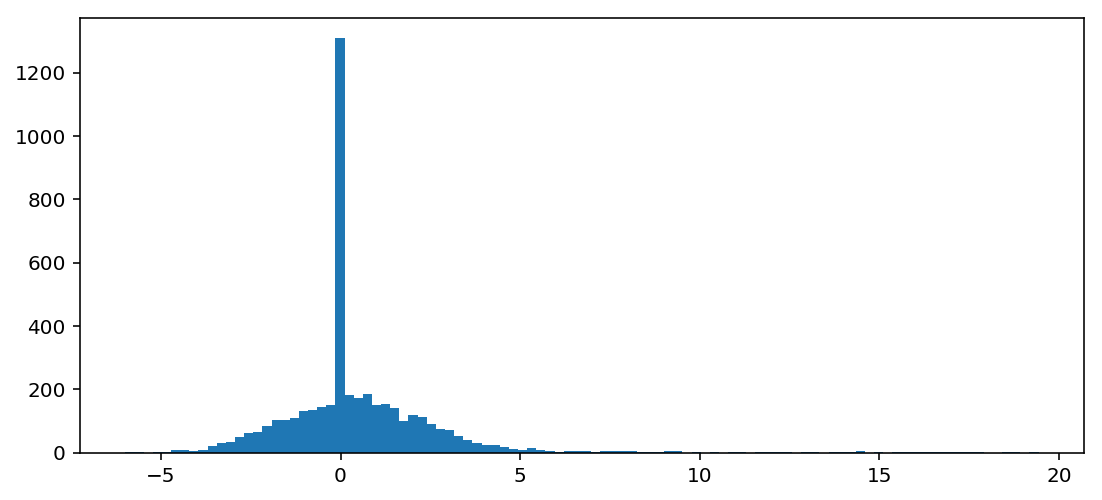

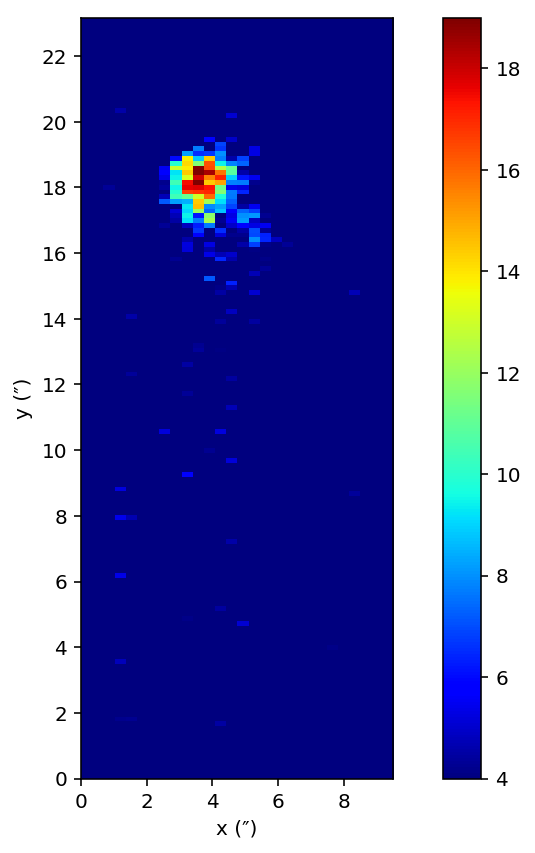

In [11]:
test_s4363 = check_cube(s4363_vvals, s4363_cube, 4363.21, 4361.75, 4366.75, 4, 19)

In [12]:
s4959_vvals, s4959_cube  = regrid_cube("green", 4958.92, 4954.00, 4967.25)

original velocity step size = 15.1137978632444
v_low = -297.4395419486545, v_high = 503.5917448032995
grid_low = -300.0, grid_high = 500.0
runtime  = 0.0780461311340332 minutes


v_low = -40.50497827349943, v_high = 352.4537661708554


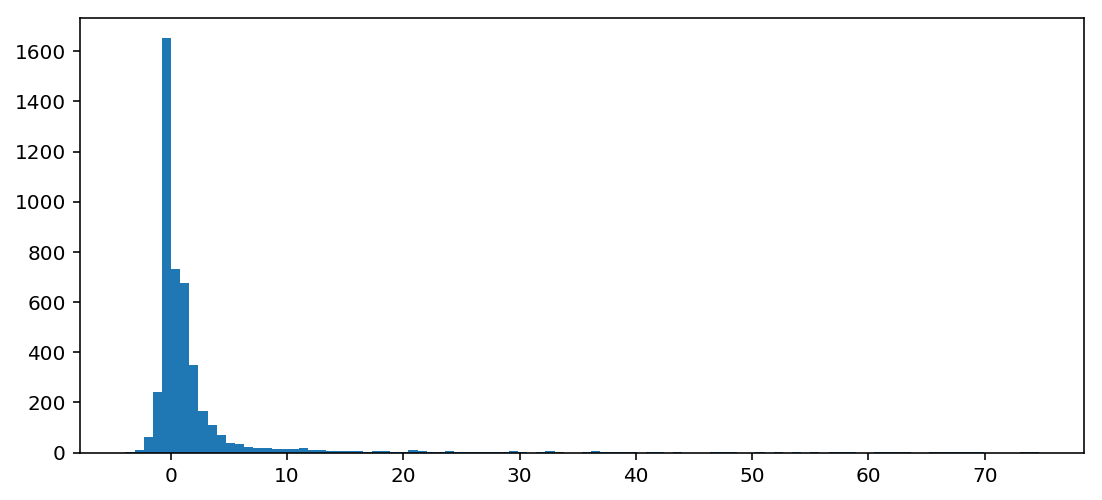

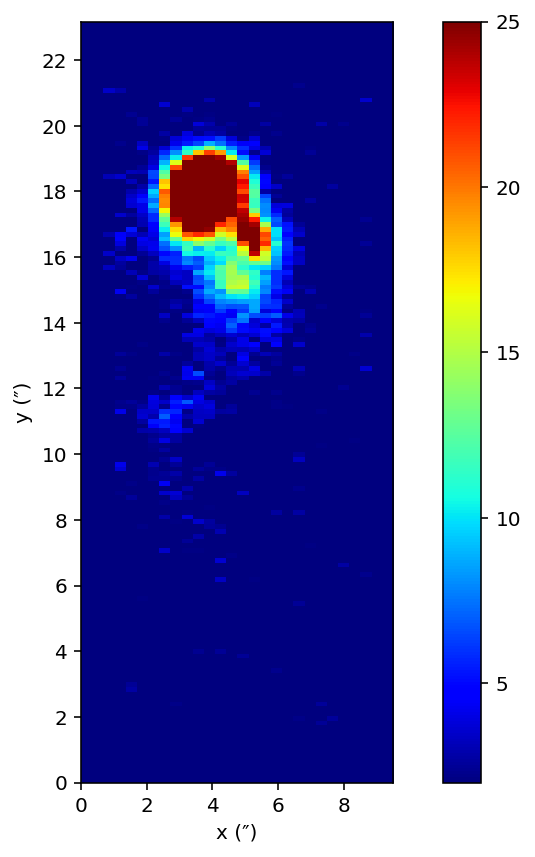

In [13]:
test_s4959 = check_cube(s4959_vvals, s4959_cube, 4958.92, 4958.25, 4964.75, 2, 25)

In [14]:
s5007_vvals, s5007_cube = regrid_cube("green", 5006.85, 5001.75, 5015.25)

original velocity step size = 14.969115212159352
v_low = -305.3699503280723, v_high = 502.96227112853205
grid_low = -310.0, grid_high = 500.0
runtime  = 0.07718800306320191 minutes


v_low = -65.86410693352288, v_high = 398.1784646434167


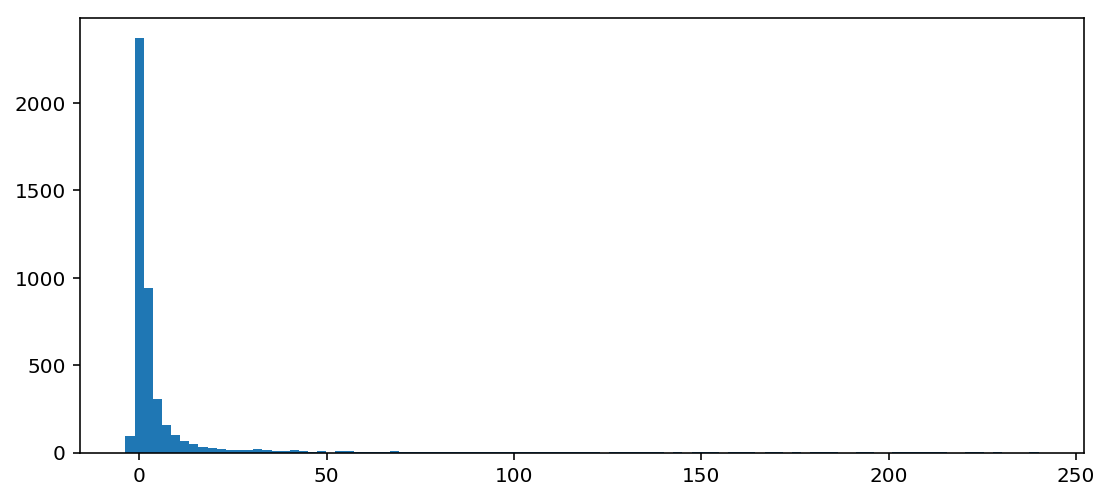

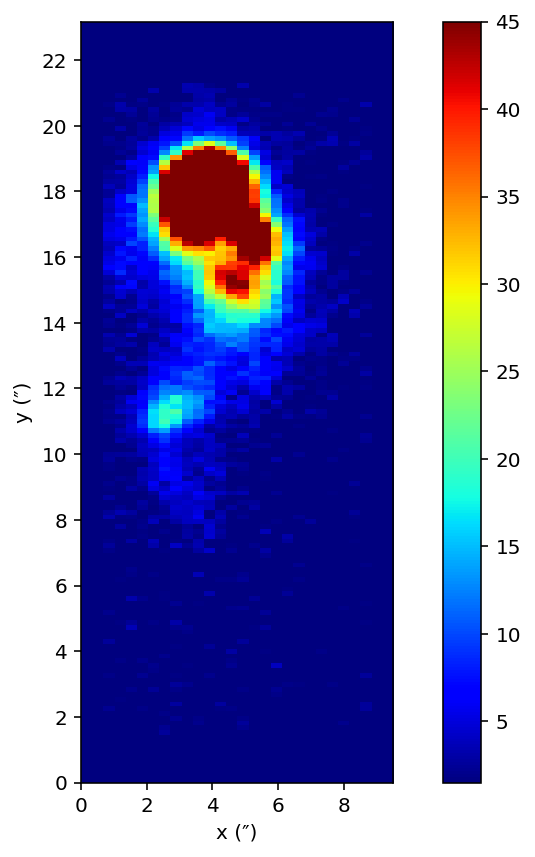

In [15]:
test_s5007 = check_cube(s5007_vvals, s5007_cube, 5006.85, 5005.75, 5013.50, 1.5, 45)

v_low = -65.86410693352288, v_high = 398.1784646434167


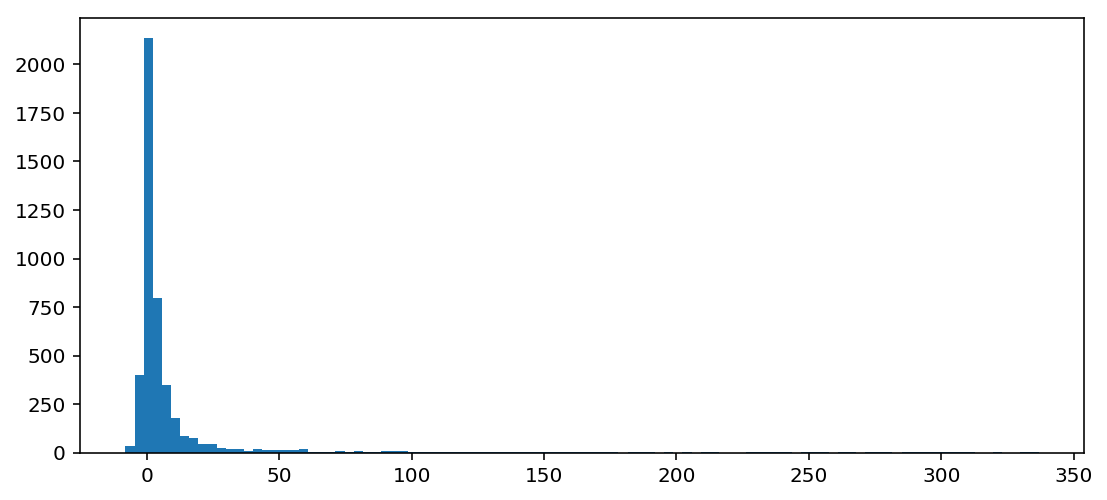

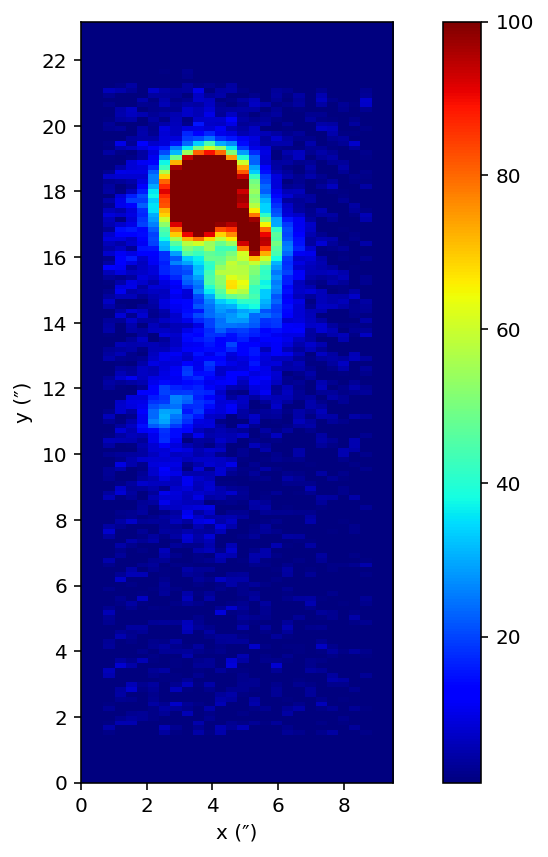

In [16]:
m_vvals, m_s4363, m_s4959 = match_grids(s4363_vvals, s4363_cube, s4959_vvals, s4959_cube)
m_vvals, m_s4959, m_s5007 = match_grids(s4959_vvals, s4959_cube, s5007_vvals, s5007_cube)

oiii_cube = m_s4363 + m_s4959 + m_s5007

test_oiii = check_cube(m_vvals, oiii_cube, 5006.85, 5005.75, 5013.50, 1, 100)

In [17]:
np.save("oiii_cube.npy", oiii_cube)
hdu = fits.PrimaryHDU()
hdu.data = oiii_cube

hdu.header['CUNIT1'] = ('deg     ', "RA units")
hdu.header['CUNIT2'] = ('deg     ', "DEC units")
hdu.header['CUNIT3'] = ('km/s    ', "Velocity units")
hdu.header['CNAME1'] = ('KCWI RA ', "RA name")
hdu.header['CNAME2'] = ('KCWI DEC' , "DEC name")
hdu.header['CNAME3'] = ('KCWI Velocity', "Velocity name")
hdu.header['CRVAL1'] = (290.123, "RA zeropoint")
hdu.header['CRVAL2'] = (11.0336, "DEC zeropoint") 
hdu.header['CRVAL3'] = (-300, "Velocity zeropoint")
hdu.header['CRPIX1'] = (10.1000, "RA reference pixel")
hdu.header['CRPIX2'] = (36.0000, "DEC reference pixel")
hdu.header['CRPIX3'] = (1.00000, "Velocity reference pixel")
hdu.header['CD1_1'] = (2.44053529605E-05, "RA degrees per column pixel")
hdu.header['CD2_1'] = (9.10819745106E-05, "DEC degrees per column pixel")
hdu.header['CD1_2'] = (3.91006768990E-05, "RA degrees per row pixel")
hdu.header['CD2_2'] = (-1.04769997120E-05, "DEC degrees per row pixel")
hdu.header['CD3_3'] = (10.0000, "Velocity km/s per pixel")
hdu.header['LONPOLE'] = (180.000, "Native longitude of Celestial pole ")
hdu.header['LATPOLE'] = (0.00000, "Celestial latitude of native pole ")

hdu.writeto('oiii_cube.fits', overwrite=True)

In [18]:
# 3726 contribution from 3722.25 - 3732.25

sep_3726 = [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 
            1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.945239, 
            0.987388, 1.00, 0.912411, 0.724304, 0.418926, 0.159387, 
            0.0395528, 0.0111664, 0.0169939, 0.0600148, 0.157747, 
            0.314639, 0.482907, 0.547666, 0.454594, 0.228935, 0.067093, 
            0.0110786, 0.00118768, 0.000121613, 0.0000105079, 6.86688*10**-7]

# 3729 contribution from 3725.00 - 3735.00

sep_3729 = [6.11317*10**-7, -2.90694*10**-6, 8.2059*10**-6, 0.000035369,
            0.000132008,  0.000352948, 0.000837554, 0.00228957, 0.0073917,
            0.0254191, 0.0791724,  0.235715, 0.545375, 0.88498, 0.985527,
            0.967944, 0.9648, 0.973029, 0.831628, 0.670663, 0.536085, 0.456332, 0.522066,
            0.741239, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 
            1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]

In [19]:
s3726_vvals, s3726_cube = regrid_cube("blue", 3726.05, 3722.25, 3732.25, sep_3726)

original velocity step size = 20.114629299123777
v_low = -305.7423653466954, v_high = 498.84280661825403
grid_low = -310.0, grid_high = 500.0
runtime  = 0.10593882004419962 minutes


v_low = -64.36681375721058, v_high = 498.84280661825403


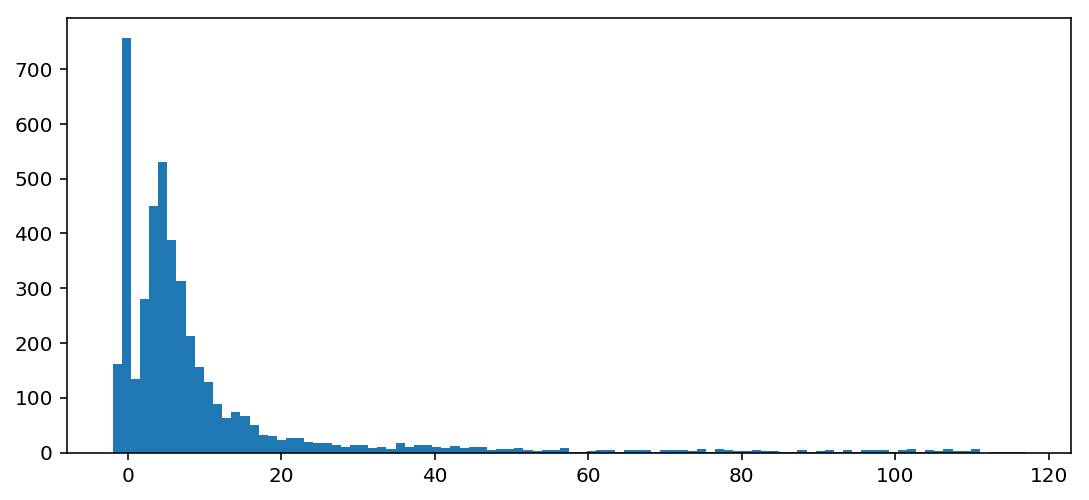

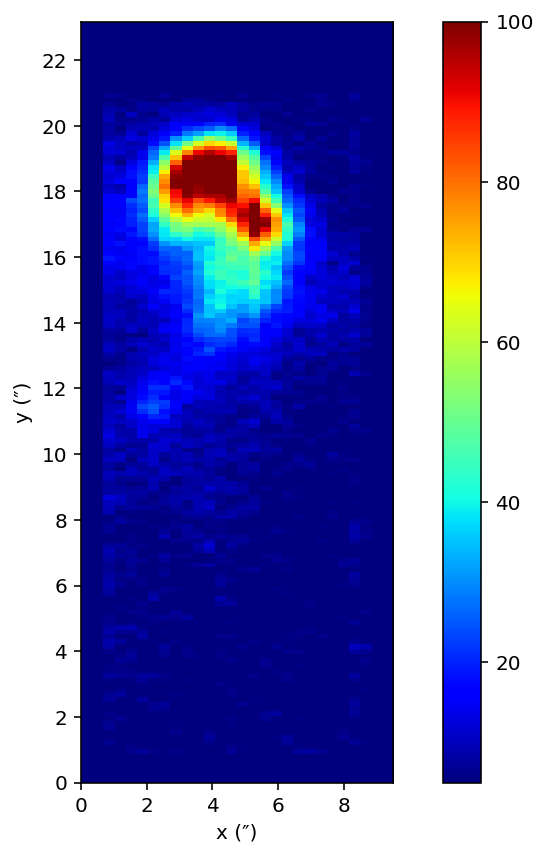

In [20]:
test_s3726 = check_cube(s3726_vvals, s3726_cube, 3726.05, 3725.25, 3732.25, 5, 100)

In [21]:
hdu = fits.PrimaryHDU()
hdu.data = s3726_cube[1:] 

hdu.header['CUNIT1'] = ('deg     ', "RA units")
hdu.header['CUNIT2'] = ('deg     ', "DEC units")
hdu.header['CUNIT3'] = ('km/s    ', "Velocity units")
hdu.header['CNAME1'] = ('KCWI RA ', "RA name")
hdu.header['CNAME2'] = ('KCWI DEC' , "DEC name")
hdu.header['CNAME3'] = ('KCWI Velocity', "Velocity name")
hdu.header['CRVAL1'] = (290.123, "RA zeropoint")
hdu.header['CRVAL2'] = (11.0336, "DEC zeropoint") 
hdu.header['CRVAL3'] = (-300, "Velocity zeropoint")
hdu.header['CRPIX1'] = (10.1000, "RA reference pixel")
hdu.header['CRPIX2'] = (36.0000, "DEC reference pixel")
hdu.header['CRPIX3'] = (1.00000, "Velocity reference pixel")
hdu.header['CD1_1'] = (2.44053529605E-05, "RA degrees per column pixel")
hdu.header['CD2_1'] = (9.10819745106E-05, "DEC degrees per column pixel")
hdu.header['CD1_2'] = (3.91006768990E-05, "RA degrees per row pixel")
hdu.header['CD2_2'] = (-1.04769997120E-05, "DEC degrees per row pixel")
hdu.header['CD3_3'] = (10.0000, "Velocity km/s per pixel")
hdu.header['LONPOLE'] = (180.000, "Native longitude of Celestial pole ")
hdu.header['LATPOLE'] = (0.00000, "Celestial latitude of native pole ")

hdu.writeto('s3726_cube.fits', overwrite=True)

In [22]:
s3729_vvals, s3729_cube = regrid_cube("blue", 3728.80, 3725.00, 3735.00, sep_3729)

original velocity step size = 20.099794706071663
v_low = -305.5168795323038, v_high = 498.4749087105625
grid_low = -310.0, grid_high = 500.0
runtime  = 0.10299939711888631 minutes


v_low = -305.5168795323038, v_high = 397.97593518020415


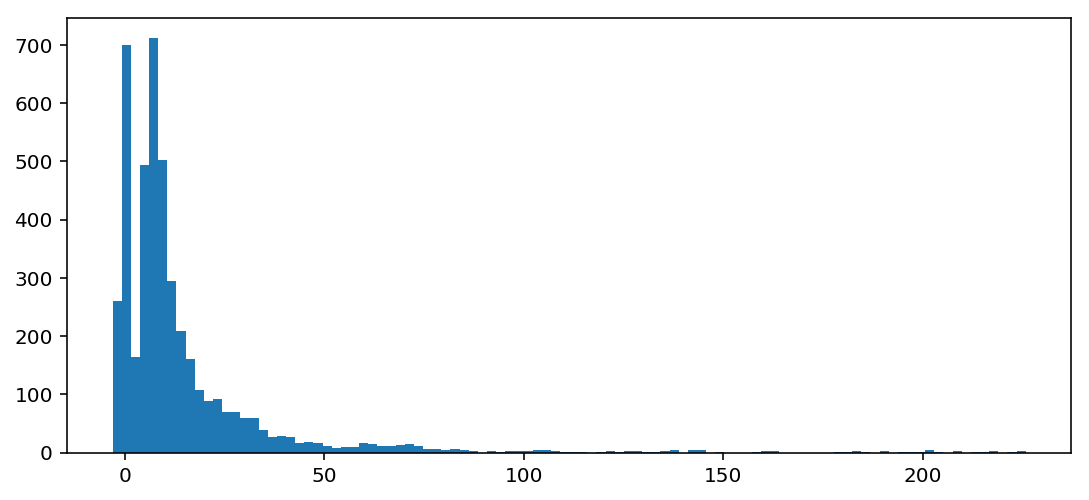

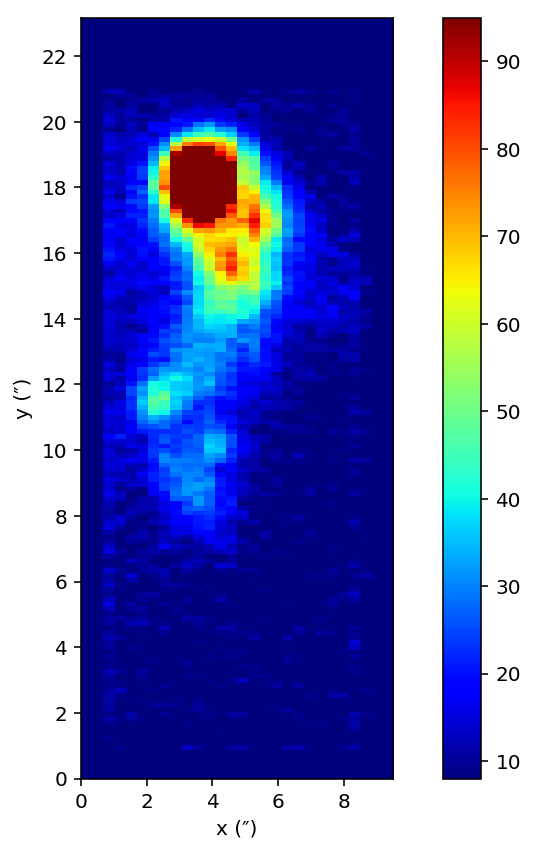

In [23]:
test_s3729 = check_cube(s3729_vvals, s3729_cube, 3728.80, 3725.00, 3733.75, 8, 95)

In [24]:
hdu = fits.PrimaryHDU()
hdu.data = s3729_cube[1:] 

hdu.header['CUNIT1'] = ('deg     ', "RA units")
hdu.header['CUNIT2'] = ('deg     ', "DEC units")
hdu.header['CUNIT3'] = ('km/s    ', "Velocity units")
hdu.header['CNAME1'] = ('KCWI RA ', "RA name")
hdu.header['CNAME2'] = ('KCWI DEC' , "DEC name")
hdu.header['CNAME3'] = ('KCWI Velocity', "Velocity name")
hdu.header['CRVAL1'] = (290.123, "RA zeropoint")
hdu.header['CRVAL2'] = (11.0336, "DEC zeropoint") 
hdu.header['CRVAL3'] = (-300, "Velocity zeropoint")
hdu.header['CRPIX1'] = (10.1000, "RA reference pixel")
hdu.header['CRPIX2'] = (36.0000, "DEC reference pixel")
hdu.header['CRPIX3'] = (1.00000, "Velocity reference pixel")
hdu.header['CD1_1'] = (2.44053529605E-05, "RA degrees per column pixel")
hdu.header['CD2_1'] = (9.10819745106E-05, "DEC degrees per column pixel")
hdu.header['CD1_2'] = (3.91006768990E-05, "RA degrees per row pixel")
hdu.header['CD2_2'] = (-1.04769997120E-05, "DEC degrees per row pixel")
hdu.header['CD3_3'] = (10.0000, "Velocity km/s per pixel")
hdu.header['LONPOLE'] = (180.000, "Native longitude of Celestial pole ")
hdu.header['LATPOLE'] = (0.00000, "Celestial latitude of native pole ")

hdu.writeto('s3729_cube.fits', overwrite=True)

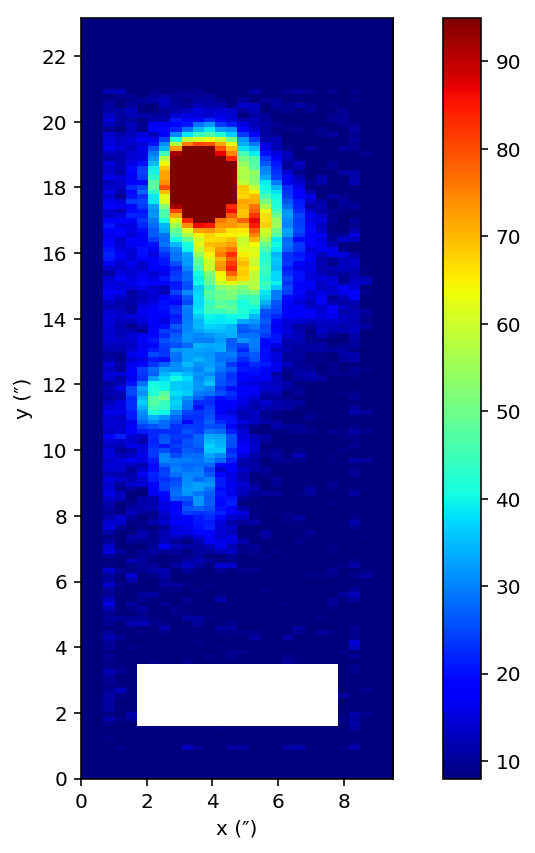

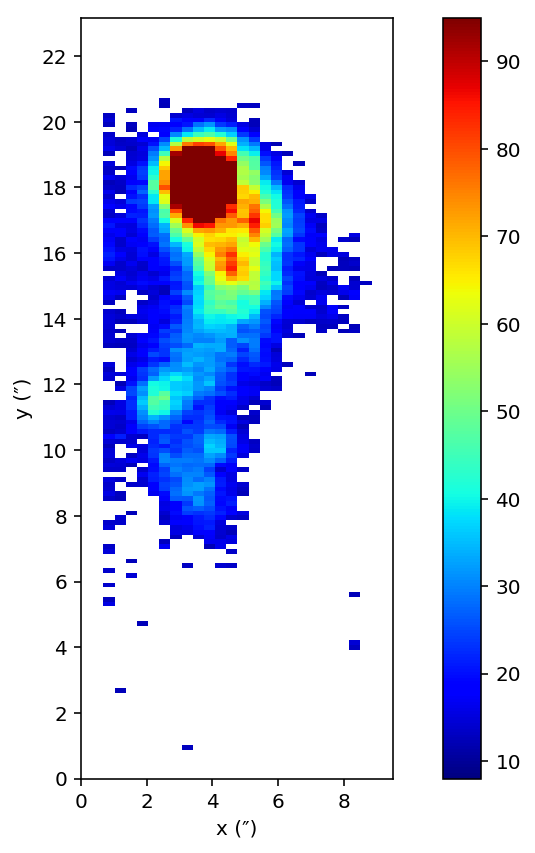

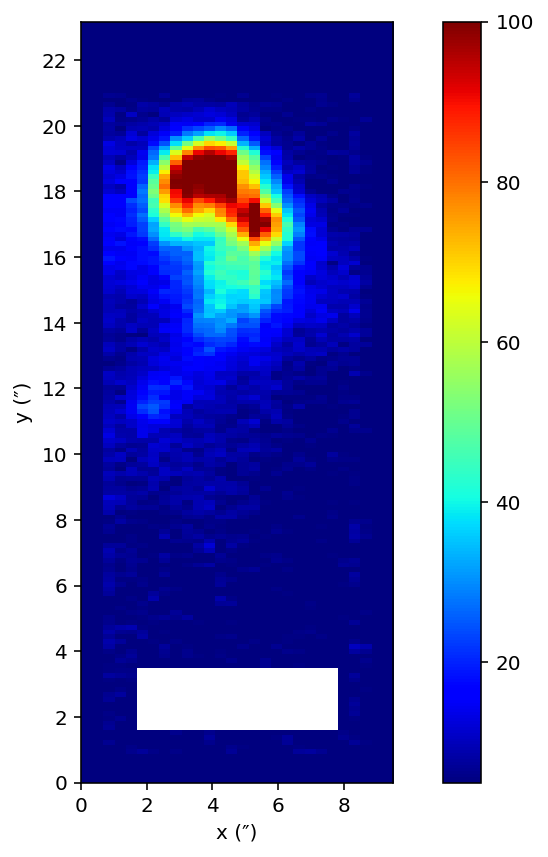

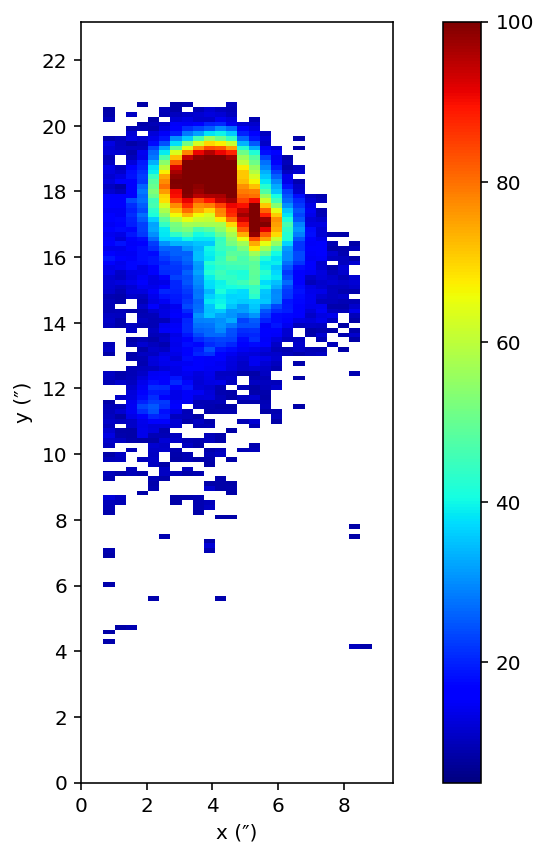

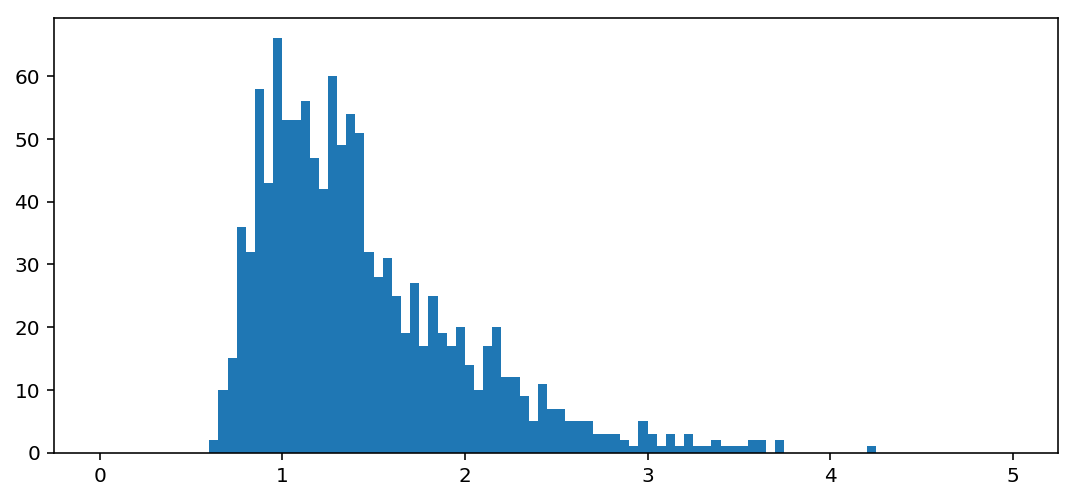

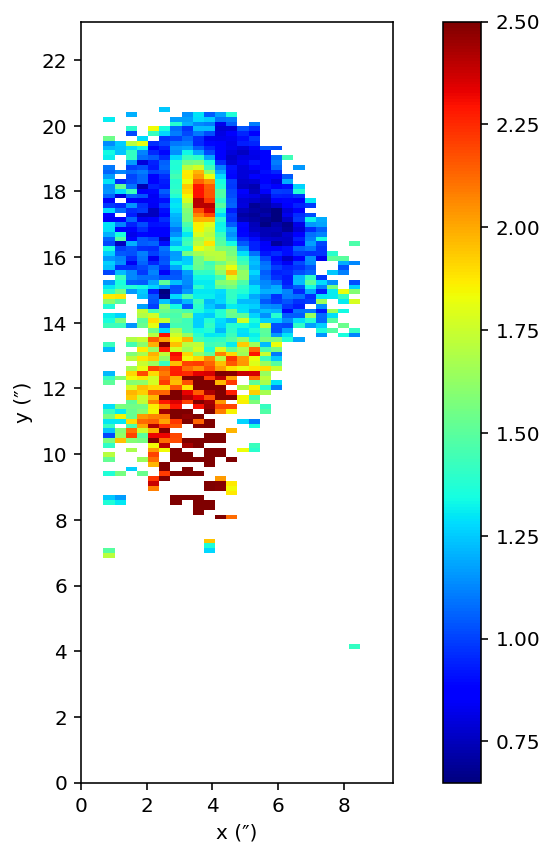

In [25]:
sum_3729c = remove_noise(test_s3729, 8, 95, 3)
sum_3726c = remove_noise(test_s3726, 5, 100, 3)

oii_oiic = sum_3729c / sum_3726c
plot_hist(oii_oiic[oii_oiic == oii_oiic], [0, 5])
plot_sum(oii_oiic, 0.65, 2.5)

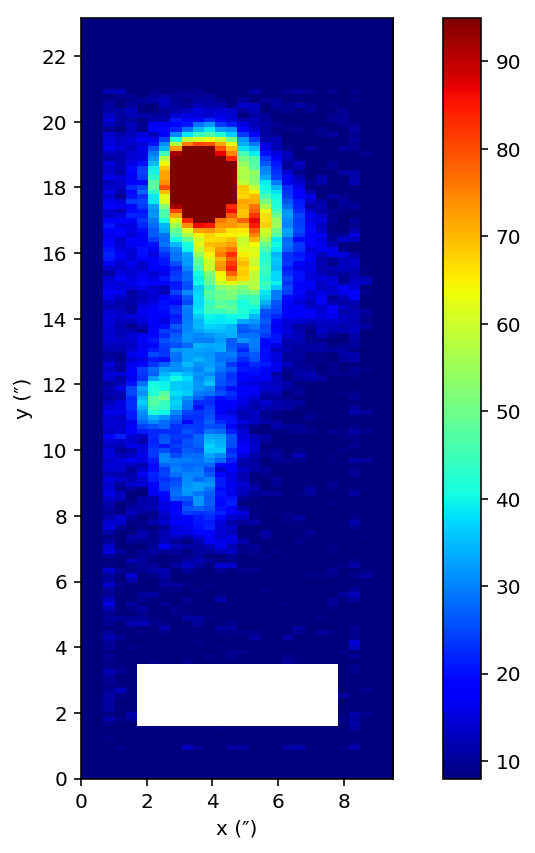

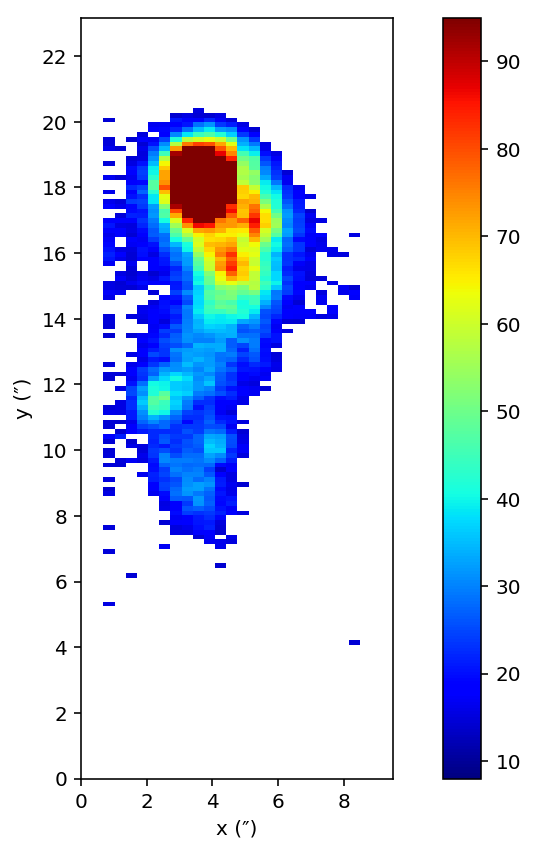

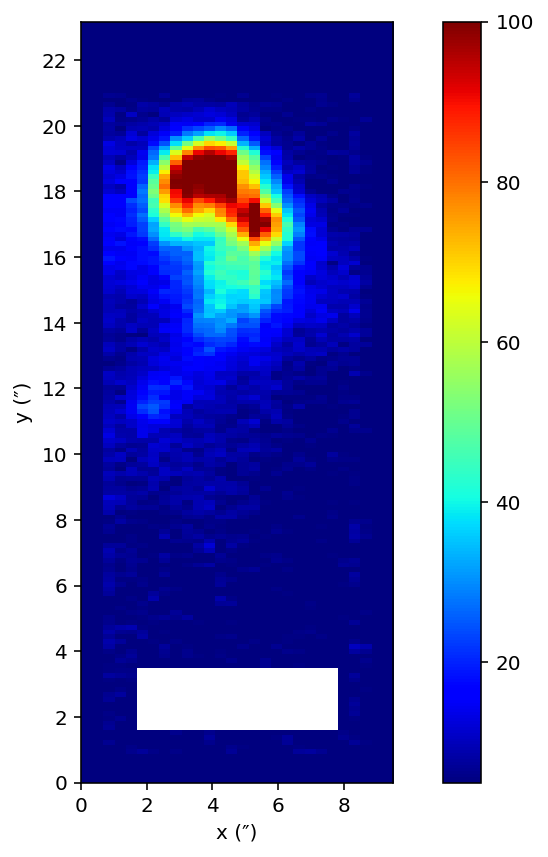

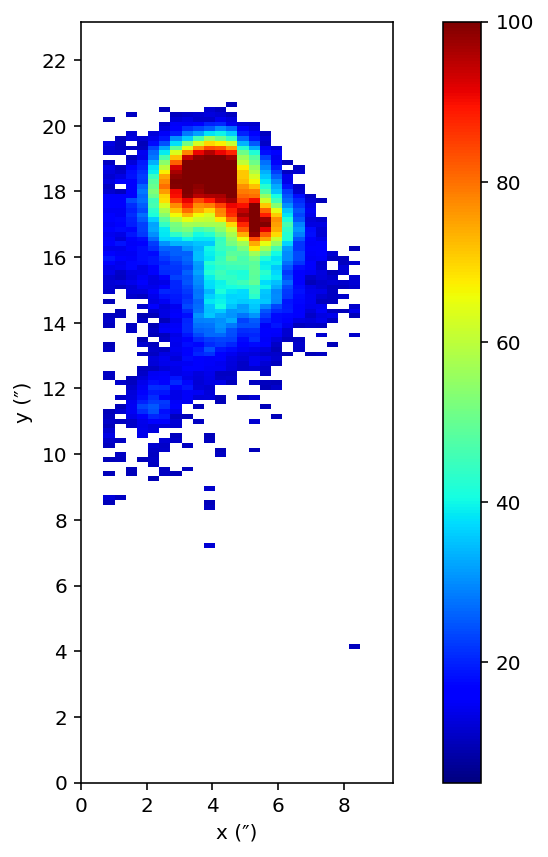

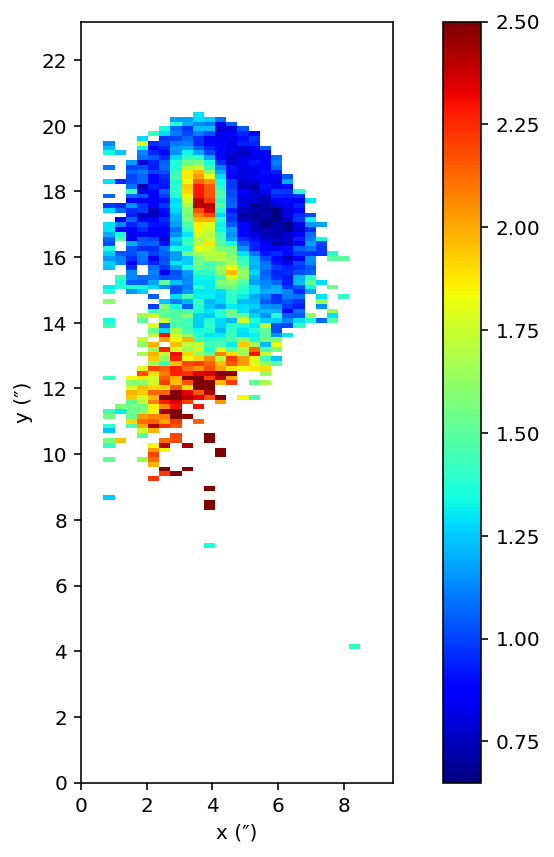

In [26]:
sum_3729c2 = remove_noise(test_s3729, 8, 95, 4)
sum_3726c2 = remove_noise(test_s3726, 5, 100, 4)

oii_oiic2 = sum_3729c2 / sum_3726c2
plot_sum(oii_oiic2, 0.65, 2.5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


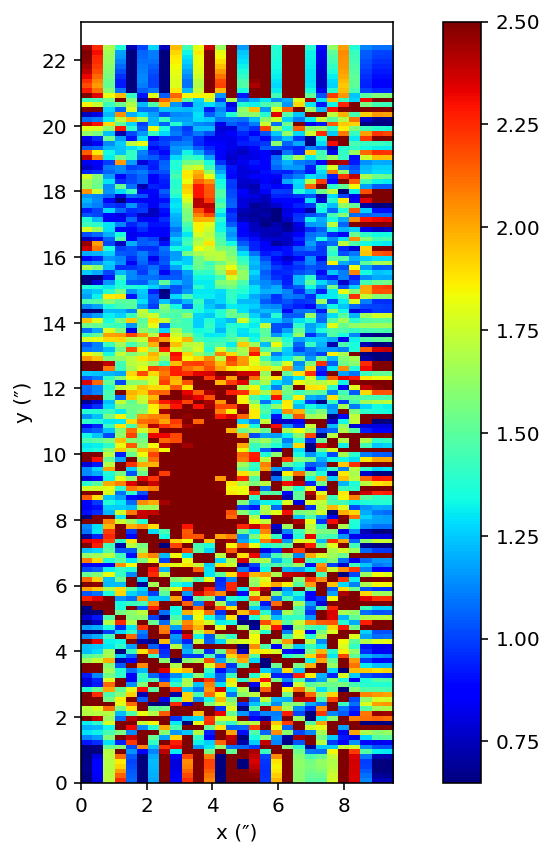

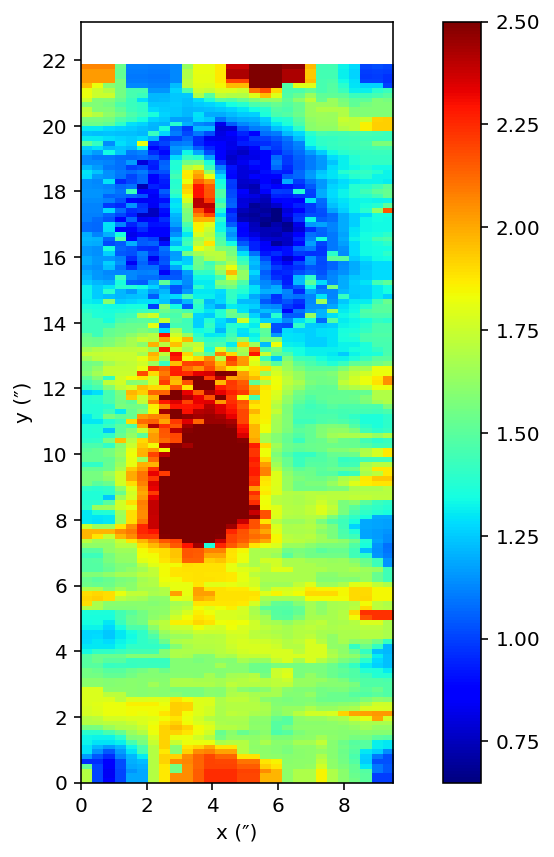

In [27]:
oii_oii = test_s3729 / test_s3726
plot_sum(oii_oii, 0.65, 2.5)
plt.show()

oii_oii_med = ndimage.median_filter(oii_oii, 8)           
        
for i in range(len(oii_oii_med)):
    for j in range(len(oii_oii_med[0])):
        if oii_oiic[i][j] == oii_oiic2[i][j]:
            oii_oii_med[i][j] = oii_oiic2[i][j]      
            
oii_oii_med[7] = None
oii_oii_med[8] = None

plot_sum(oii_oii_med, 0.65, 2.5)
plt.show()

v_low = -164.93996025282925, v_high = 498.84280661825403


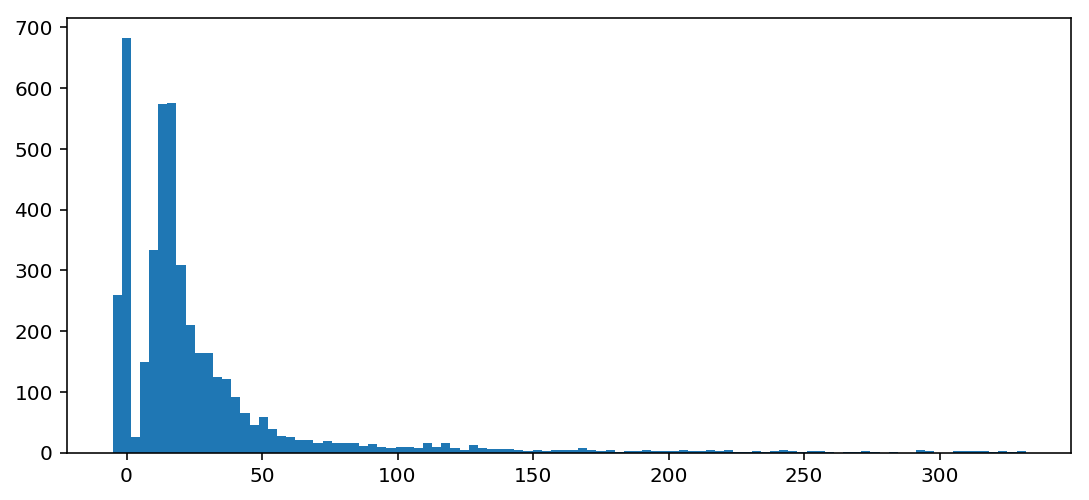

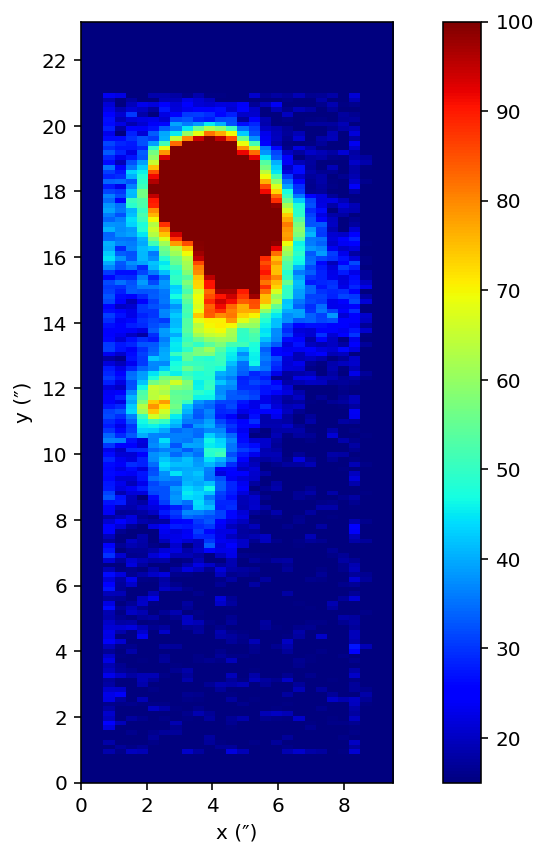

In [28]:
oii_cube = s3726_cube[1:] + s3729_cube[1:]

test_oii = check_cube(s3729_vvals[1:], oii_cube, 3726.05, 3724.00, 3732.25, 15, 100)

In [29]:
np.save("oii_cube.npy", oii_cube)
hdu = fits.PrimaryHDU()
hdu.data = oii_cube

hdu.header['CUNIT1'] = ('deg     ', "RA units")
hdu.header['CUNIT2'] = ('deg     ', "DEC units")
hdu.header['CUNIT3'] = ('km/s    ', "Velocity units")
hdu.header['CNAME1'] = ('KCWI RA ', "RA name")
hdu.header['CNAME2'] = ('KCWI DEC' , "DEC name")
hdu.header['CNAME3'] = ('KCWI Velocity', "Velocity name")
hdu.header['CRVAL1'] = (290.123, "RA zeropoint")
hdu.header['CRVAL2'] = (11.0336, "DEC zeropoint") 
hdu.header['CRVAL3'] = (-300, "Velocity zeropoint")
hdu.header['CRPIX1'] = (10.1000, "RA reference pixel")
hdu.header['CRPIX2'] = (36.0000, "DEC reference pixel")
hdu.header['CRPIX3'] = (1.00000, "Velocity reference pixel")
hdu.header['CD1_1'] = (2.44053529605E-05, "RA degrees per column pixel")
hdu.header['CD2_1'] = (9.10819745106E-05, "DEC degrees per column pixel")
hdu.header['CD1_2'] = (3.91006768990E-05, "RA degrees per row pixel")
hdu.header['CD2_2'] = (-1.04769997120E-05, "DEC degrees per row pixel")
hdu.header['CD3_3'] = (10.0000, "Velocity km/s per pixel")
hdu.header['LONPOLE'] = (180.000, "Native longitude of Celestial pole ")
hdu.header['LATPOLE'] = (0.00000, "Celestial latitude of native pole ")

hdu.writeto('oii_cube.fits', overwrite=True)

In [41]:
wv_lst = np.arange(3715, 3740+0.25, 0.25)

flux_lst = []

start = wave2pix(3715, "blue")
end = wave2pix(3740, "blue")
length = -start + end

for i in range(length+1):
        flux_lst.append(np.sum(hdu_list_blue[0].data[:, :, :][start + i]) / 1000)
        
data = np.array([wv_lst,  flux_lst]).T

np.savetxt("old_3727.txt", data, fmt=['%1.2f', '%1.6f'])

In [40]:
data

array([[3715.        ,   10.18307007],
       [3715.25      ,   10.26707275],
       [3715.5       ,   10.24318604],
       [3715.75      ,   10.42839722],
       [3716.        ,   10.25849854],
       [3716.25      ,   10.66588013],
       [3716.5       ,    9.99430969],
       [3716.75      ,    9.90763428],
       [3717.        ,   10.11898743],
       [3717.25      ,    9.85879639],
       [3717.5       ,   10.33955322],
       [3717.75      ,    9.93265442],
       [3718.        ,    9.90150085],
       [3718.25      ,   10.00757507],
       [3718.5       ,   10.09305725],
       [3718.75      ,   10.86733643],
       [3719.        ,   10.95632446],
       [3719.25      ,   11.00883423],
       [3719.5       ,   11.46326416],
       [3719.75      ,   12.20087769],
       [3720.        ,   12.58492187],
       [3720.25      ,   11.89040894],
       [3720.5       ,   11.5135083 ],
       [3720.75      ,   11.06218262],
       [3721.        ,   10.85677979],
       [3721.25      ,   

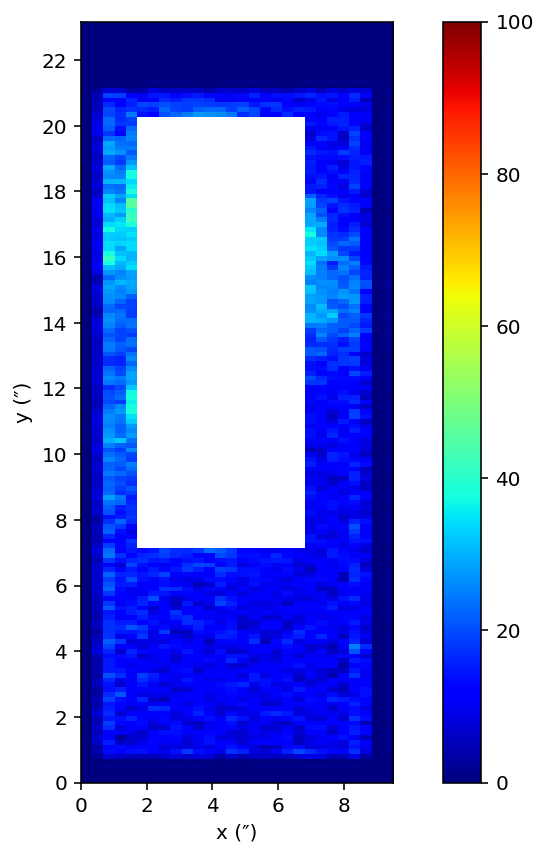

In [53]:
sum_3727 = make_sum(3725.25, 3733.75, "blue")

sum_3727[20:110, 5:20] = None
plot_sum(sum_3727, 0, 100)

In [42]:
wv_lst = np.arange(3715, 3740+0.25, 0.25)

flux_lst = []

start = wave2pix(3715, "blue")
end = wave2pix(3740, "blue")
length = -start + end

for i in range(length+1):
        flux_lst.append(np.sum(hdu_list_blue[0].data[start + i]) / 100)
        
data = np.array([wv_lst,  flux_lst]).T

np.savetxt("test2.txt", data, fmt=['%1.2f', '%1.6f'])